<a href="https://colab.research.google.com/github/tingiskhan/pyfilter/blob/self_exciting_calibration/examples/self-exciting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let us import the daily dataset 'InputData/ENEL_10may19_10may20.csv' and the 'self_exciting.py' file which contains the distributions required to run the calibration procedure.

In [ ]:

from google.colab import files
data = files.upload() # upload data from InputData
# uploaded = files.upload() # upload self_exciting.py

Saving self_exciting.py to self_exciting.py


Saving ENEL_10may19_10may20.csv to ENEL_10may19_10may20.csv


This is a Google Colab example to run the $SMC^2$ PMCMC algorithm over a given dataset of daily levels for the Italian asset ENEL, see e.g. 'InputData/ENEL_10may19_10may20.csv'.
The goal is to calibrate the process using the self-exciting model described by Hainaut and Moraux (2016), we made use of some peculiar distributions contained in the particlefiltering package.
Colab has been chosen since it allows us to perform $SMC^2$ algorithm using the GPU, although it may not be present in your laptop. This choice leads to an impressive improvement in terms of computational time required by the calibration routine.

In [ ]:
# https://pypi.org/project/pfilter/
!pip install git+https://github.com/tingiskhan/pyfilter.git
%load self_exciting.py
# !pip install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp27-cp27mu-linux_x86_64.whl 
!pip install pyro-ppl
from pyfilter.timeseries import StateSpaceModel, AffineObservations
from self_exciting import LambdaProcess, NegativeExponential
import torch
from torch.distributions import Normal, Beta, Exponential, LogNormal, Uniform, AbsTransform, AffineTransform, TransformedDistribution
from pyfilter.distributions import DistributionWrapper, Prior, JointDistribution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfilter.inference.sequential import SMC2
from arviz import plot_posterior
from pyfilter.filters import APF, SISR
from pyfilter import __version__ as pyfilter_v
from torch import __version__ as torch_v

from pyro.distributions import Delta
import platform

  Cloning https://github.com/tingiskhan/pyfilter.git to /tmp/pip-req-build-zbtjgcyz
  Running command git clone -q https://github.com/tingiskhan/pyfilter.git /tmp/pip-req-build-zbtjgcyz
  Created wheel for pyfilter: filename=pyfilter-0.20.14-py3-none-any.whl size=104975 sha256=7aac5b1039bde7dd9234660ce68018836c584043883ee8dd0a0ff16660d23602
  Stored in directory: /tmp/pip-ephem-wheel-cache-ocgx7g6b/wheels/68/60/cc/0e6bf6ce3aeff33ff6ced48a7877f675cf92b74674fbc03151
Successfully built pyfilter


ValueError: ignored

Let us check the python, pyfilter and Torch version.

In [1]:
print('Python version: {}'.format(platform.python_version()))
print('Pyfilter version: {}'.format(pyfilter_v))
print('Torch: {}'.format(torch_v))

NameError: ignored

Let us set the initial guesses for the paramters compounding the model.

In [ ]:
dt = 1 / 252
scaling_factor = 100.
guessed_alpha = 16.78593266
guessed_xi = 5.18576927
guessed_eta = 420.09103858
guessed_mu = 0.7610505809397193 * scaling_factor
guessed_sigma = 0.18946154023364034 * scaling_factor
guessed_p = 0.42756757439716864
guessed_rho_plus = 14.627643390477822 / scaling_factor
guessed_rho_minus = -18.359586687875716 / scaling_factor


def go_0(multi_process, level):
    """
    Args:
        multi_process: ((lambda_t)_t, (dN_t)_t, (lambda_{t-1})_{t-1}, {J_i}_{i \in [0,...,N_t]}) note that the second process is just denoting the increments; dN_t \in {0,1}
        level: state of observation

    Returns:

    """
    dN_t = multi_process.values[..., 1]

    lambda_s = multi_process.values[..., 2]
    q = multi_process.values[..., 3]

    ans = level - (guessed_mu - .5 * guessed_sigma ** 2 - lambda_s * multi_process.mu_j) * dt - q * dN_t
    return ans


def fo(multi_process, level):
    return bi_process.values[..., 0]

def fo0(bi_process, level):
    return torch.Tensor([1.]).cuda()


def forward_hook(model, inputs, new_state):
    new_state.register_buffer("mu_j", model.de.build_distribution().phi_fun)

    return

priors_lambda = (
    Prior(Exponential, rate=1 / guessed_alpha),                           # Alpha
    Prior(LogNormal, loc= 1 / guessed_xi, scale=1.0),                   # Xi
    Prior(LogNormal, loc= 1 / guessed_eta, scale=1.0),                   # Eta
    Prior(Uniform, low=0.0, high=1.0),    # p
    Prior(NegativeExponential, rate= 1 / guessed_rho_minus),                           # Rho minus
    Prior(Exponential, rate= 1 / guessed_rho_plus)                            # Rho plus
)



def init_transform(lambda_proc: LambdaProcess, dist: Normal):
    alpha, xi, eta = lambda_proc.functional_parameters()

    de = lambda_proc.de.build_distribution()
    batch_shape = de.batch_shape
    # dist_ = TransformedDistribution(dist, [AffineTransform(xi, eta / (2 * alpha).sqrt()), AbsTransform()])
    # lambda_infty = (alpha * xi) / (alpha * eta * de.mu_j)
    exp_lambda = xi
    exp_j2 = de.p * 2 / (de.rho_plus ** 2) + (1 - de.p)* 2 / (de.rho_minus ** 2)
    variance_lambda = exp_j2
    # dist_ = TransformedDistribution(dist, [AffineTransform(xi, eta / (2 * alpha).sqrt()), AbsTransform()])
    dist_ = TransformedDistribution(dist, [AffineTransform(exp_lambda, variance_lambda.sqrt()), AbsTransform()])

    return JointDistribution(
        dist_,
        Delta(torch.zeros(batch_shape, device=xi.device)),
        dist_,
        de
    )


lambda_process = LambdaProcess(
    *priors_lambda,
    dt=dt,
    num_steps=4,
    initial_dist=DistributionWrapper(Normal, loc=0.0, scale=1.0),
    initial_transform=init_transform
)

lambda_process.register_forward_hook(forward_hook)

obs = AffineObservations((go_0, fo), (Prior(Normal, loc=0., scale=1.0),), DistributionWrapper(Normal, loc=0.0, scale=1.0))
stockmodel = StateSpaceModel(lambda_process, obs)

data_path = r'/content/ENEL_10may19_10may20.csv'
dataframe = pd.read_csv(data_path, header=0, sep=',', index_col=0, parse_dates=True)

log_r = np.log(dataframe["Adj_Close"]).diff().iloc[1:] * scaling_factor

predictions = 5
training = torch.from_numpy(log_r.values[:-predictions]).float().cuda()

n_particles = 500
threshold = 0.5

algs = list()
for i in range(2):
    filt = SISR(stockmodel.copy(), n_particles)
    alg = SMC2(filt, 2_000, threshold=threshold, n_steps=2).cuda()

    state = alg.fit(training)

    algs.append((state, alg))

Python version: 3.7.12
Pyfilter version: 0.20.13
Torch: 1.10.0+cu111


SMC2: 100%|██████████| 246/246 [03:50<00:00,  1.07it/s]


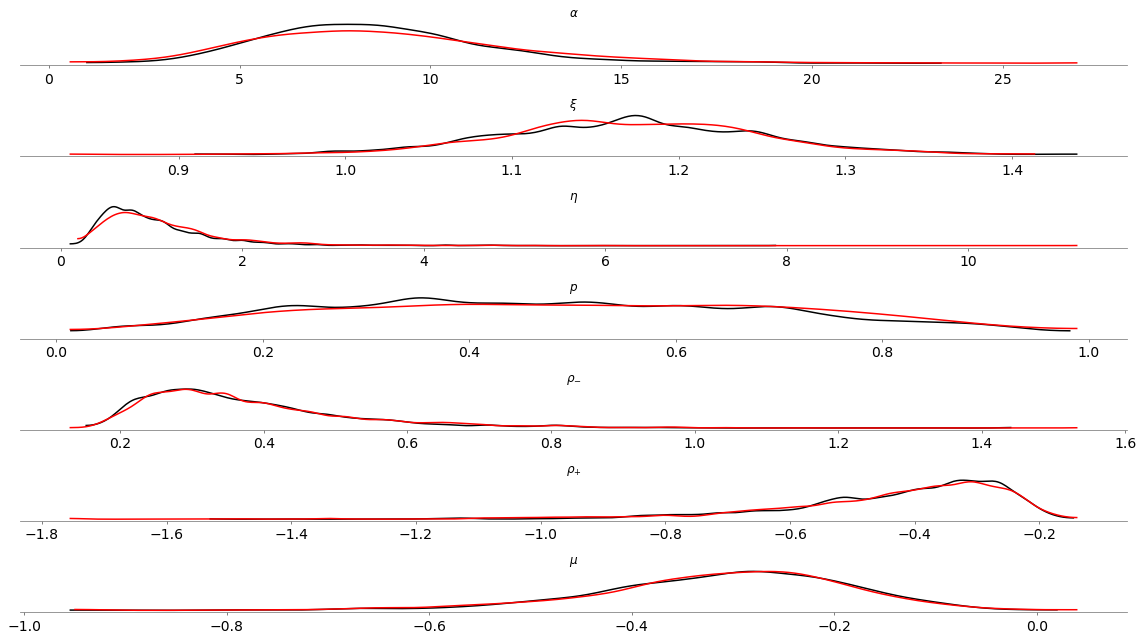

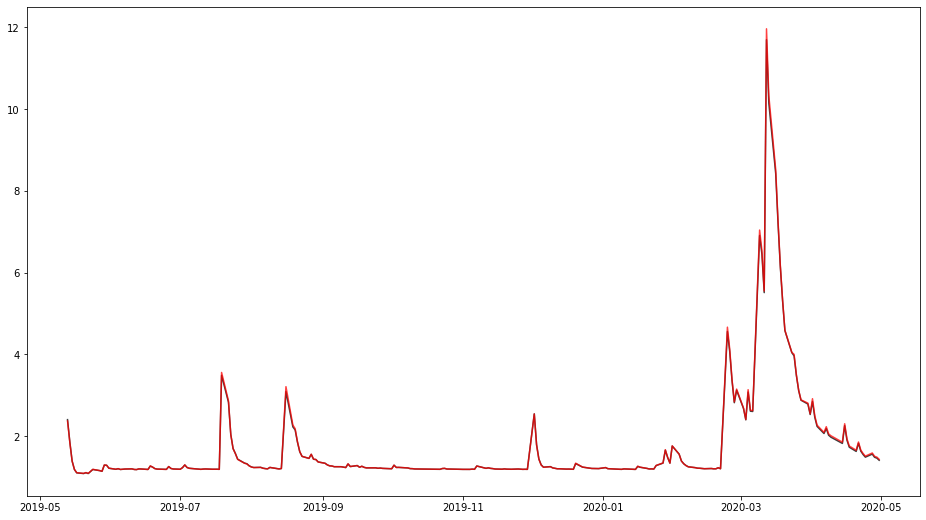

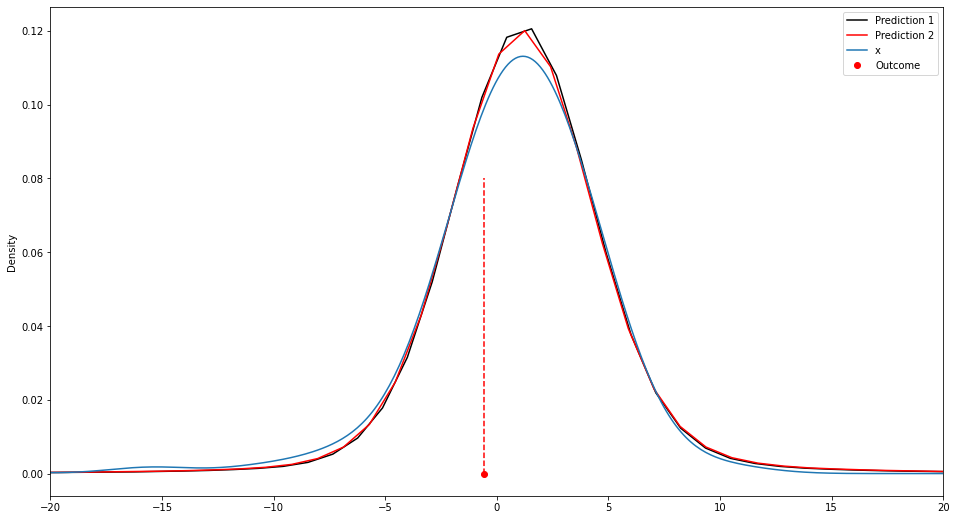

In [ ]:
fig, ax = plt.subplots(len(tuple(alg.filter.ssm.parameters())), figsize=(16, 9))

colors = ["black", "red"]
names = "\\alpha, \\xi, \\eta, p, \\rho_{-}, \\rho_{+}, \\mu".split(',')

for j, (state, alg) in enumerate(algs):
    w = state.normalized_weights()
    for i, param in enumerate(alg.filter.ssm.parameters()):
        plot_posterior(param.squeeze().cpu().numpy(), ax=ax[i], color=colors[j], point_estimate=None, hdi_prob='hide')
        ax[i].set_title(f"${names[i]}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 9))

for i, (state, alg) in enumerate(algs):
    ax.plot(
        log_r.index[:-predictions],
        state.filter_state.filter_means[1:, ..., 0].mean(1).cpu().numpy(),
        color=colors[i],
        alpha=0.75
    )

plt.show()


fig, ax = plt.subplots(figsize=(16, 9))

for i, (state, alg) in enumerate(algs):
    _, yt = alg.predict(predictions, state, aggregate=False)

    mask = yt.abs() > 100.0
    yt[mask] = 100.0 * yt[mask].sign()

    final = pd.Series(yt.sum(0).view(-1).cpu().numpy()).sort_values()[::50]

    final.plot.kde(ax=ax, label=f"Prediction {i + 1:d}", color=colors[i])

log_r.iloc[:-predictions].rolling(predictions).sum().plot.kde(ax=ax, label='x')
# log_r[f'Historic rolling {predictions:d} day returns'] = log_r.iloc[:-predictions].rolling(predictions).sum()

ax.set_xlim(-20, 20)
log_r5 = log_r.iloc[-predictions:].sum()
ax.plot([log_r5, log_r5], [0.0, 0.08], "r--")
ax.plot(log_r5, 0.0, "ro", label="Outcome")

ax.legend()
plt.show()

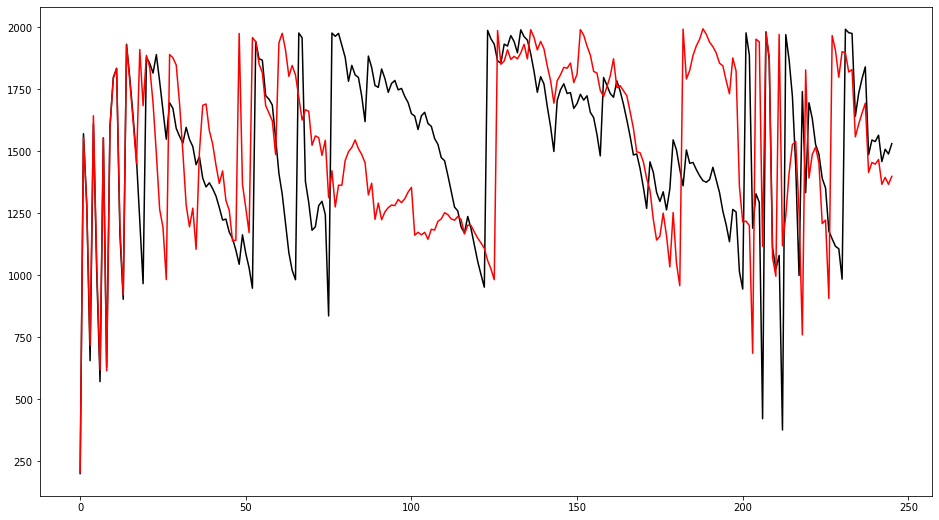

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (state, _) in enumerate(algs):
    ax.plot(state.ess.values().cpu().numpy(), color=colors[i])